In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import yfinance as yf
import fredapi as fd
import plotly.graph_objects as go
from prophet import Prophet

pd.set_option("future.no_silent_downcasting", True)

In [2]:
#set the column and rows to fit properly in the table so column and row names can be visible
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#view and make sure that data is correct and visible for analysis
oil = yf.Ticker("CL=F")
df_oil = oil.history(period="5y")
display(df_oil.head())
                

Open       High        Low      Close  Volume  \
Date                                                                            
2020-09-08 00:00:00-04:00  39.480000  39.590000  36.130001  36.759998  720975   
2020-09-09 00:00:00-04:00  36.790001  38.450001  36.160000  38.049999  455356   
2020-09-10 00:00:00-04:00  37.799999  38.180000  36.930000  37.299999  367555   
2020-09-11 00:00:00-04:00  37.009998  37.820000  36.669998  37.330002  363787   
2020-09-14 00:00:00-04:00  37.320000  37.680000  36.820000  37.259998  347563   

                           Dividends  Stock Splits  
Date                                                
2020-09-08 00:00:00-04:00        0.0           0.0  
2020-09-09 00:00:00-04:00        0.0           0.0  
2020-09-10 00:00:00-04:00        0.0           0.0  
2020-09-11 00:00:00-04:00        0.0           0.0  
2020-09-14 00:00:00-04:00        0.0           0.0

In [3]:
#step 4 is to highlight the commodity tickers I want from yfinance using dictionary so they are easily retrievable in the notebook for data analysis
commodity_tickers ={
    "Crude Oil (WTI)": "CL=F",
    "Brent Oil": "BZ=F",
    "Gasoline": "RB=F",
    "Natural Gas": "NG=F",
}

#step 5 is to fetch the historical data for all commodities of interest using for loop
commodity_data = {}
for name, ticker in commodity_tickers.items():
        commodity_data[name] = yf.Ticker(ticker).history(period="5y")["Close"]

#step 6 is to convert commodity data to a DataFrame
df_commodities = pd.DataFrame(commodity_data)

display(df_commodities.head())

Crude Oil (WTI)  Brent Oil  Gasoline  Natural Gas
Date                                                                        
2020-09-08 00:00:00-04:00        36.759998  39.779999    1.1028        2.400
2020-09-09 00:00:00-04:00        38.049999  40.790001    1.1193        2.406
2020-09-10 00:00:00-04:00        37.299999  40.060001    1.0977        2.323
2020-09-11 00:00:00-04:00        37.330002  39.830002    1.0949        2.269
2020-09-14 00:00:00-04:00        37.259998  39.610001    1.1068        2.310

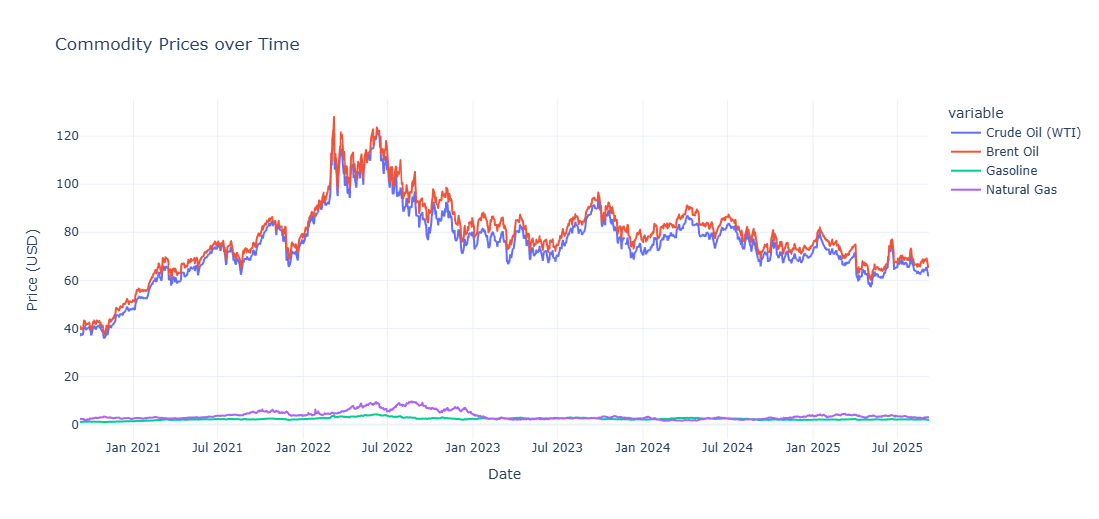

In [4]:
#step 7 is to convert the index to columns to make it complaitble for Plotly use
df_commodities = df_commodities.reset_index()

#step 8 is to create an interactive line chart in Plotly to show price of commodities 
fig = px.line(
    df_commodities, x="Date", y=df_commodities.columns[1:], 
    title="Commodity Prices over Time", 
    labels={"value":"Price (USD)", "Date":"Date"}, 
    template="plotly_white", width = 1100, height = 500
)

fig.show()

DEBUG	Task(Task-5) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-5) cmdstanpy:model.py:__init__()- Adding TBB (C:\Users\Gloria Daniel\anaconda3\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
INFO	Task(Task-5) prophet:forecaster.py:parse_seasonality_args()- Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG	Task(Task-5) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\GLORIA~1\AppData\Local\Temp\tmp7qlc93zb\5cs_dc1j.json
DEBUG	Task(Task-5) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\GLORIA~1\AppData\Local\Temp\tmp7qlc93zb\1eo_glps.json
DEBUG	Task(Task-5) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-5) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	Task(Task-5) cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['C:\\Users\\Gloria Daniel\\anaconda3\\Lib\\site-packages\\prophet\\stan_m

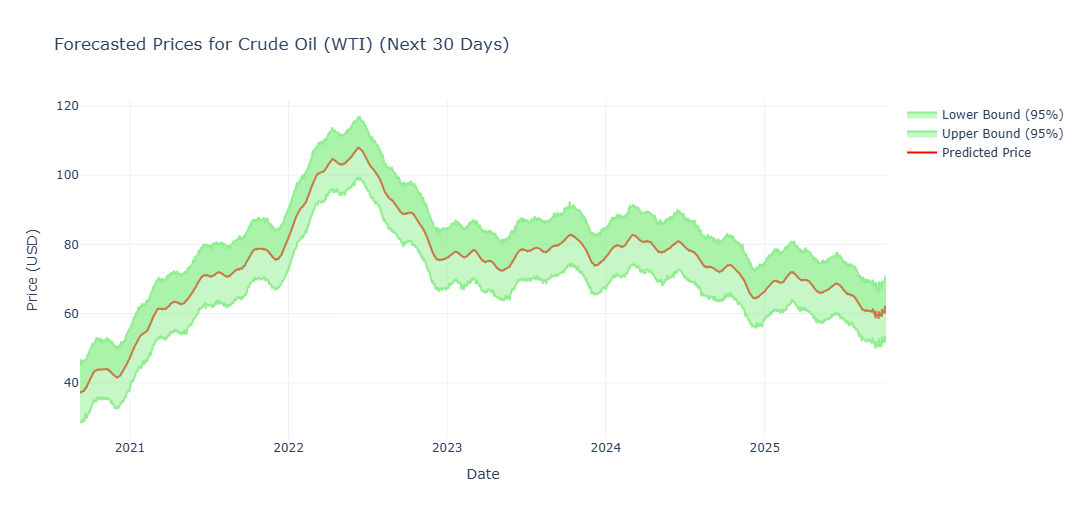

ds       yhat  yhat_upper  yhat_lower
1283 2025-10-03  60.975625   69.231519   52.411628
1284 2025-10-04  59.969335   69.138406   51.615737
1285 2025-10-05  62.242891   70.533146   53.626826
1286 2025-10-06  61.289221   70.525694   52.475027
1287 2025-10-07  61.323928   69.814887   52.755082

In [5]:
#use prophet to forecast/predict price movement for the next 30 days
#first I will highlight the commodity I want to predict
commodity_name ="Crude Oil (WTI)"
commodity_ticker ="CL=F"

# then next is to fetch the historical data for the commodity, in this instance, crude oil
df_commodity = yf.Ticker(commodity_ticker).history(period="5y")["Close"].reset_index()
df_commodity = df_commodity.rename(columns={"Date":"ds", "Close":"y"})
df_commodity["ds"] = pd.to_datetime(df_commodity["ds"]).dt.tz_localize(None) # here I am removing the timezone from the commodity data

#prophecy begins... first I will fit the prophet based on the confidence level I want
model = Prophet(interval_width=0.95) # I'll go with 95% confidence
model.fit(df_commodity)

future_dates = model.make_future_dataframe(periods=30, freq="D") # this generates/creates the future dates for the next 90 days

forecast = model.predict(future_dates) # this predicts the future price
forecast= forecast[["ds", "yhat", "yhat_upper", "yhat_lower"]] #ds is for date, yhat is the predicted price, yhat_upper is the highest price it can go and yhat_lower is the lowest predicted price

fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat"],
                         mode="lines", name="Predicted Price", line=dict(color="red")))
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_upper"],
                         mode="lines", name="Upper Bound (95%)", line=dict(color="lightgreen"), fill="tonexty"))
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_lower"],
                         mode="lines", name="Lower Bound (95%)", line=dict(color="lightgreen"), fill="tonexty")) 
fig.update_layout(
    title=f"Forecasted Prices for {commodity_name} (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    template="plotly_white", width=1100, height=500
)

fig.show()
display(forecast.tail(5))

DEBUG	Task(Task-5) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-5) cmdstanpy:model.py:__init__()- TBB already found in load path
INFO	Task(Task-5) prophet:forecaster.py:parse_seasonality_args()- Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG	Task(Task-5) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\GLORIA~1\AppData\Local\Temp\tmp7qlc93zb\w_5jkud5.json
DEBUG	Task(Task-5) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\GLORIA~1\AppData\Local\Temp\tmp7qlc93zb\fzd4ml97.json
DEBUG	Task(Task-5) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-5) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	Task(Task-5) cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['C:\\Users\\Gloria Daniel\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=60547', 'data', 'file=C:\\Users\\GLORIA~1\\AppData\\Local\\T

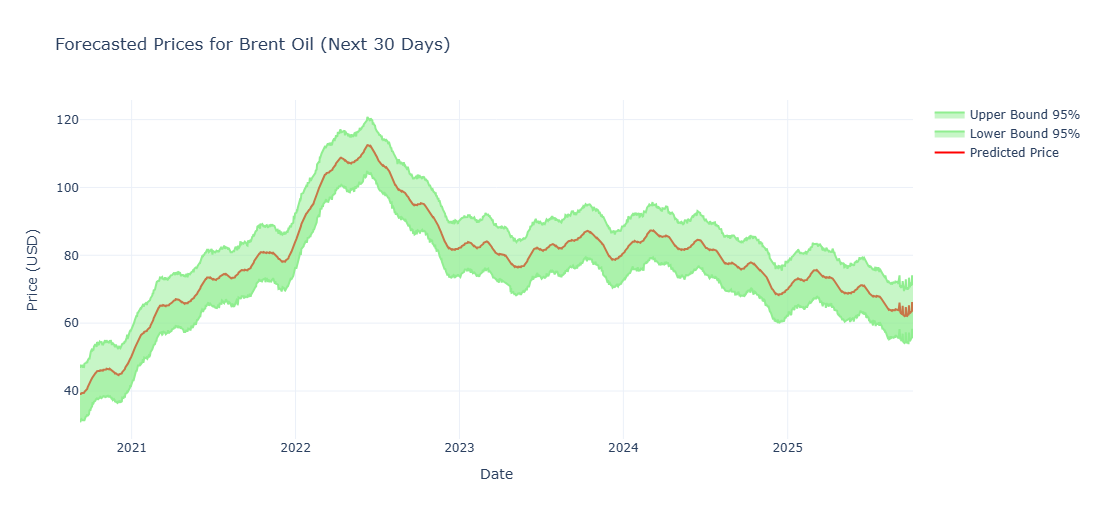

ds       yhat  yhat_lower  yhat_upper
1284 2025-10-03  63.502589   55.702339   71.073752
1285 2025-10-04  63.291695   55.737483   71.331523
1286 2025-10-05  66.217480   58.355935   74.101930
1287 2025-10-06  63.757410   55.595537   71.239256
1288 2025-10-07  63.801923   56.038893   72.804924

In [6]:
#doing same for brent
commodity_name = "Brent Oil"
commodity_ticker ="BZ=F"


df_commodity = yf.Ticker(commodity_ticker).history(period="5y")[["Close"]].reset_index()
df_commodity = df_commodity.rename(columns={"Date":"ds", "Close":"y"})
df_commodity["ds"] = pd.to_datetime(df_commodity["ds"]).dt.tz_localize(None) # here I am removing the timezone from the commodity data

model = Prophet(interval_width=0.95)
model.fit(df_commodity)

future_dates = model.make_future_dataframe(periods=30, freq="D")
forecast = model.predict (future_dates) 
forecast = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]


fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat"], mode="lines", name="Predicted Price", line=dict(color="red")))
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_lower"], mode="lines", name="Lower Bound 95%", line=dict(color="lightgreen"), fill="tonexty"))
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_upper"], mode="lines", name="Upper Bound 95%", line=dict(color="lightgreen"), fill="tonexty"))

fig.update_layout(
    title=f"Forecasted Prices for {commodity_name} (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    template="plotly_white", width=1100, height=500
)

fig.show()
print()
display(forecast.tail(5))

In [7]:
import os
print(os.getcwd())

C:\Users\Gloria Daniel\Zipporah's First Time Using Jupyter\Python Finance Project


In [8]:
!pip install python-dotenv
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path="FREDAPI.env")

# Retrieve the API key
api_key = os.getenv("FRED_API_KEY")

# Check if the key loaded correctly
if api_key:
    print("API key loaded successfully")
else:
    print("API key NOT found")

# Use the API key in FRED connection
fred = fd.Fred(api_key=api_key)

API key loaded successfully


In [9]:
data = fred.search("nominal broad dollar index")
data.head(2)

id realtime_start realtime_end  \
series id                                            
DTWEXBGS      DTWEXBGS     2025-09-07   2025-09-07   
TWEXBGSMTH  TWEXBGSMTH     2025-09-07   2025-09-07   

                                      title observation_start observation_end  \
series id                                                                       
DTWEXBGS    Nominal Broad U.S. Dollar Index        2006-01-02      2025-08-29   
TWEXBGSMTH  Nominal Broad U.S. Dollar Index        2006-01-01      2025-08-01   

           frequency frequency_short               units         units_short  \
series id                                                                      
DTWEXBGS       Daily               D  Index Jan 2006=100  Index Jan 2006=100   
TWEXBGSMTH   Monthly               M  Index Jan 2006=100  Index Jan 2006=100   

                seasonal_adjustment seasonal_adjustment_short  \
series id                                                       
DTWEXBGS    Not Seasonally Adjusted                       NSA   
TWEXBGSMTH  Not Seasonally Adjusted                       NSA   

                         last_updated popularity notes  
series id                                               
DTWEXBGS    2025-09-02 15:19:49-05:00         81  None  
TWEXBGSMTH  2025-09-02 15:19:41-05:00         60  None

In [10]:
data=fred.search("weekly economic index")
data.head(1)

id realtime_start realtime_end  \
series id                                    
WEI        WEI     2025-09-07   2025-09-07   

                                                 title observation_start  \
series id                                                                  
WEI        Weekly Economic Index (Lewis-Mertens-Stock)        2008-01-05   

          observation_end                frequency frequency_short  units  \
series id                                                                   
WEI            2025-08-30  Weekly, Ending Saturday               W  Index   

          units_short      seasonal_adjustment seasonal_adjustment_short  \
series id                                                                  
WEI             Index  Not Seasonally Adjusted                       NSA   

                        last_updated popularity  \
series id                                         
WEI        2025-09-04 10:35:40-05:00         65   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               notes  
series id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

ds         y
0 2006-01-02  101.4155
1 2006-01-03  100.7558
2 2006-01-04  100.2288
3 2006-01-05  100.2992
4 2006-01-06  100.0241

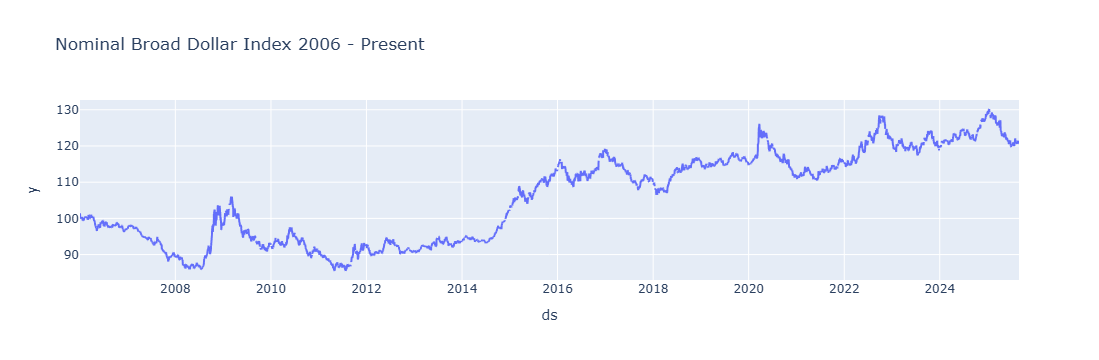

In [11]:
usd=fred.get_series("DTWEXBGS")
df_usd=pd.DataFrame(usd).reset_index()
df_usd = df_usd.rename(columns={0:"y", "index":"ds"})
display(df_usd.head())

fig=px.line(df_usd, x="ds", y="y", title="Nominal Broad Dollar Index 2006 - Present")
fig.show()

DEBUG	Task(Task-5) cmdstanpy:command.py:do_command()- cmd: where.exe tbb.dll
cwd: None
DEBUG	Task(Task-5) cmdstanpy:model.py:__init__()- TBB already found in load path
INFO	Task(Task-5) prophet:forecaster.py:parse_seasonality_args()- Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG	Task(Task-5) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\GLORIA~1\AppData\Local\Temp\tmp7qlc93zb\3f63i_nb.json
DEBUG	Task(Task-5) cmdstanpy:filesystem.py:_temp_single_json()- input tempfile: C:\Users\GLORIA~1\AppData\Local\Temp\tmp7qlc93zb\0l42_7pk.json
DEBUG	Task(Task-5) cmdstanpy:model.py:_run_cmdstan()- idx 0
DEBUG	Task(Task-5) cmdstanpy:model.py:_run_cmdstan()- running CmdStan, num_threads: None
DEBUG	Task(Task-5) cmdstanpy:model.py:_run_cmdstan()- CmdStan args: ['C:\\Users\\Gloria Daniel\\anaconda3\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=41277', 'data', 'file=C:\\Users\\GLORIA~1\\AppData\\Local\\T

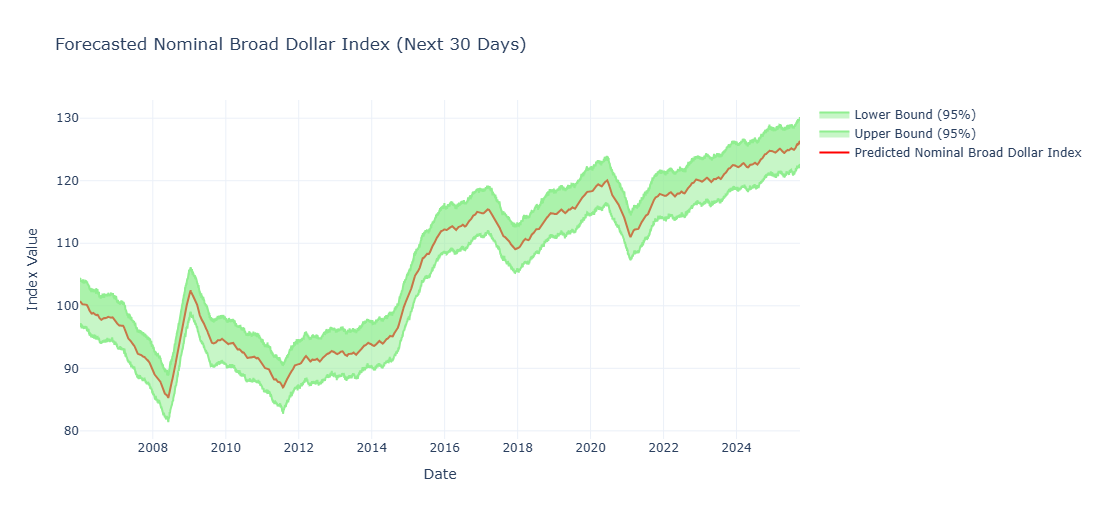

ds        yhat  yhat_upper  yhat_lower
5155 2025-09-24  126.080531  129.747668  121.999202
5156 2025-09-25  126.105872  129.809438  122.526753
5157 2025-09-26  126.128390  129.962051  122.575843
5158 2025-09-27  126.358554  130.199409  122.662325
5159 2025-09-28  126.388891  129.835858  122.691713

In [12]:
df_usd["ds"] = pd.to_datetime(df_usd["ds"]).dt.tz_localize(None)

model = Prophet(interval_width=0.95) # 95% confidence
model.fit(df_usd)

future_dates = model.make_future_dataframe(periods=30, freq="D") # this generates/creates the future dates for the next 30 days

forecast = model.predict(future_dates) # this predicts the future price
forecast= forecast[["ds", "yhat", "yhat_upper", "yhat_lower"]] #ds is for date, yhat is the predicted price, yhat_upper is the highest price it can go and yhat_lower is the lowest predicted price

# use plotly graph objects to visualize
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat"],
                         mode="lines", name="Predicted Nominal Broad Dollar Index", line=dict(color="red")))
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_upper"],
                         mode="lines", name="Upper Bound (95%)", line=dict(color="lightgreen"), fill="tonexty"))
fig.add_trace(go.Scatter(x=forecast["ds"], y=forecast["yhat_lower"],
                         mode="lines", name="Lower Bound (95%)", line=dict(color="lightgreen"), fill="tonexty")) 
fig.update_layout(
    title=f"Forecasted Nominal Broad Dollar Index (Next 30 Days)",
    xaxis_title="Date",
    yaxis_title="Index Value",
    template="plotly_white", width=1100, height=500
)
#show the Plotly Chart
fig.show()
display(forecast.tail(5))

In [13]:
wei=fred.get_series("WEI")
df_wei=pd.DataFrame(wei).reset_index()
df_wei = df_wei.rename(columns={0:"y", "index":"ds"})
display(df_wei.head())

fig=px.line(df_wei, x="ds", y="y", title="Weekly Economic Index 2008 - Present")
fig.show()

ds     y
0 2008-01-05  1.94
1 2008-01-12  1.93
2 2008-01-19  1.90
3 2008-01-26  1.41
4 2008-02-02  1.13

In [14]:
#define the economic indicators (nominal broad dollar index and weekly economic index)
usdstrength_symbol = "DTWEXBGS" # Nominal Broad Dollar Index
economicindex_symbol = "WEI" # Weekly Economic Index


# Fetch series and convert to DataFrame
df_usdstrength = fred.get_series(usdstrength_symbol, start=df_commodities["Date"].min(), end=df_commodities["Date"].max()).to_frame(name="Nominal Broad Dollar Index")
df_usdstrength.index.name = "Date"

df_economicindex = fred.get_series(economicindex_symbol, start=df_commodities["Date"].min(), end=df_commodities["Date"].max()).to_frame(name="Weekly Economic Index")
df_economicindex.index.name = "Date"

#reset index to merge with commodities
df_usdstrength = df_usdstrength.reset_index()
df_economicindex = df_economicindex.reset_index()

display(df_usdstrength.head())
display(df_economicindex.tail())

#merge with commodity prices using merge_asof() for better date alignment 
df_commodities["Date"] = pd.to_datetime(df_commodities["Date"]).dt.tz_localize(None) #remove timezone
df_usdstrength["Date"] = pd.to_datetime(df_usdstrength["Date"])
df_economicindex["Date"] = pd.to_datetime(df_economicindex["Date"])

df_commodities = pd.merge_asof(df_commodities.sort_values("Date"), df_usdstrength.sort_values("Date"), left_on="Date", right_on="Date", direction="backward")
df_commodities = pd.merge_asof(df_commodities.sort_values("Date"), df_economicindex.sort_values("Date"), left_on="Date", right_on="Date", direction="backward")

display(df_commodities.head())
display(df_commodities.tail())

#plot commodity prices vs USD Strength and Economic Activity
fig = px.line(
    df_commodities, x="Date", y=["Crude Oil (WTI)", "Brent Oil", "Nominal Broad Dollar Index", "Weekly Economic Index"],
    title="Commodity Prices vs USD Strength and Economic Activity",
    template="plotly_white", width=1100, height=500
)

fig.show()

Date  Nominal Broad Dollar Index
0 2006-01-02                    101.4155
1 2006-01-03                    100.7558
2 2006-01-04                    100.2288
3 2006-01-05                    100.2992
4 2006-01-06                    100.0241

Date  Weekly Economic Index
917 2025-08-02                   2.59
918 2025-08-09                   2.50
919 2025-08-16                   2.53
920 2025-08-23                   2.61
921 2025-08-30                   2.52

Date  Crude Oil (WTI)  Brent Oil  Gasoline  Natural Gas  Copper  \
0 2020-09-08        36.759998  39.779999    1.1028        2.400  3.0125   
1 2020-09-09        38.049999  40.790001    1.1193        2.406  3.0400   
2 2020-09-10        37.299999  40.060001    1.0977        2.323  2.9870   
3 2020-09-11        37.330002  39.830002    1.0949        2.269  3.0340   
4 2020-09-14        37.259998  39.610001    1.1068        2.310  3.0665   

          Gold   Micro Gold  Silver  Micro Silver  Nominal Broad Dollar Index  \
0  1933.000000  1935.099976  26.864        26.864                    116.4725   
1  1944.699951  1946.800049  26.955        26.955                    116.1396   
2  1954.199951  1956.000000  27.163        27.163                    115.8906   
3  1937.800049  1939.500000  26.739        26.739                    116.0963   
4  1953.099976  1954.699951  27.229        27.229                    115.6523   

   Weekly Economic Index  
0                  -2.28  
1                  -2.28  
2                  -2.28  
3                  -2.28  
4                  -3.39

Date  Crude Oil (WTI)  Brent Oil  Gasoline  Natural Gas  Copper  \
1254 2025-09-02        65.589996  69.139999    2.0428        3.009  4.5695   
1255 2025-09-03        63.970001  67.599998    2.0120        3.064  4.5585   
1256 2025-09-04        63.480000  66.989998    2.0095        3.074  4.4880   
1257 2025-09-05        61.869999  65.500000    1.9642        3.048  4.4825   
1258 2025-09-07        62.080002  65.750000    1.9675        3.073  4.5530   

             Gold   Micro Gold     Silver  Micro Silver  \
1254  3549.399902  3562.899902  41.070999     41.070999   
1255  3593.199951  3606.100098  41.542000     41.542000   
1256  3565.800049  3577.300049  40.910999     40.910999   
1257  3613.199951  3624.000000  41.074001     41.074001   
1258  3629.199951  3629.399902  41.375000     41.369999   

      Nominal Broad Dollar Index  Weekly Economic Index  
1254                    120.6028                   2.52  
1255                    120.6028                   2.52  
1256                    120.6028                   2.52  
1257                    120.6028                   2.52  
1258                    120.6028                   2.52

In [13]:
North_America_Rig_Count = "08-29-2025 North America Rig Count Report.xlsx"

# Load NAM Monthly but skip the messy top rows
df = pd.read_excel(North_America_Rig_Count, sheet_name="NAM Monthly", skiprows=6, header=0)

# Drop all-empty columns and rows
df = df.dropna(axis=1, how="all")
df = df.dropna(axis=0, how="all")

# Reset index
df = df.reset_index(drop=True)
df.columns = ["Country", "County", "Basin", "GOM", "DrillFor", "Location", "State/Province", "Trajectory", "Year", "Month", "Rig Count Value"]
df = df.drop(index=0).reset_index(drop=True)

display(df.head(7))

C:\Users\Gloria Daniel\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning:

Unknown extension is not supported and will be removed



Country                County  Basin GOM DrillFor Location State/Province  \
0  CANADA       FOOTHILLS FRONT  Other  No      Gas     Land        ALBERTA   
1  CANADA  SOUTHEASTERN ALBERTA  Other  No      Gas     Land        ALBERTA   
2  CANADA  EAST CENTRAL ALBERTA  Other  No      Oil     Land        ALBERTA   
3  CANADA       FOOTHILLS FRONT  Other  No      Oil     Land        ALBERTA   
4  CANADA  NORTHEASTERN ALBERTA  Other  No      Oil     Land        ALBERTA   
5  CANADA  NORTHWESTERN ALBERTA  Other  No      Oil     Land        ALBERTA   
6  CANADA  SOUTHEASTERN ALBERTA  Other  No      Oil     Land        ALBERTA   

    Trajectory  Year Month Rig Count Value  
0  Directional  2013     1               6  
1  Directional  2013     1            2.75  
2  Directional  2013     1            9.75  
3  Directional  2013     1               1  
4  Directional  2013     1             9.5  
5  Directional  2013     1            2.75  
6  Directional  2013     1            2.25

In [14]:
print(df.columns)

Index(['Country', 'County', 'Basin', 'GOM', 'DrillFor', 'Location',
       'State/Province', 'Trajectory', 'Year', 'Month', 'Rig Count Value'],
      dtype='object')


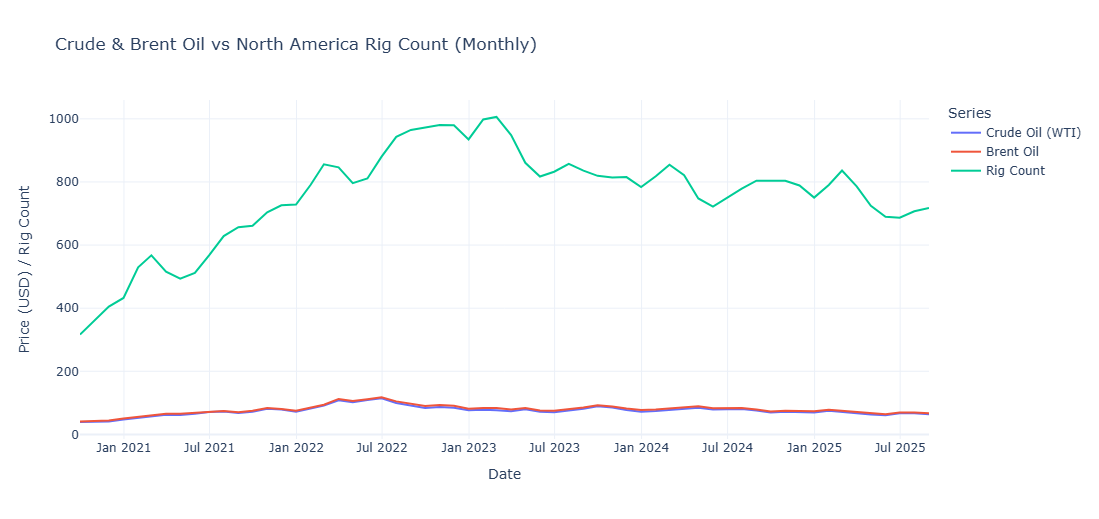

In [15]:
# Change the Month column to numbers, maybe this can resolve the errors in previous code?
month_map = {
    "Jan":1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6,
    "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12
}
df["Month"] = df["Month"].replace(month_map)
df["Month"] = pd.to_numeric(df["Month"], errors="coerce")
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df["Rig Count Value"] = pd.to_numeric(df["Rig Count Value"], errors="coerce")

# Drop rows 
df = df.dropna(subset=["Year", "Month", "Rig Count Value"])

# create a month-end Date so rigs align with monthly oil averages
df["Date"] = pd.to_datetime({
    "year": df["Year"].astype(int),
    "month": df["Month"].astype(int),
    "day": 1
}) + pd.offsets.MonthEnd(0)

#group the rigs
df_rigs = (df.groupby("Date", as_index=False)["Rig Count Value"]
             .sum()
             .rename(columns={"Rig Count Value": "Rig Count"}))

# Oil monthly average (month-end)
df_commodities["Date"] = pd.to_datetime(df_commodities["Date"]).dt.tz_localize(None)
df_oil_m = (df_commodities.set_index("Date")
            .resample("ME")[["Crude Oil (WTI)", "Brent Oil"]]
            .mean()
            .reset_index())

# Ensure evverything is in numbers just in case
for c in ["Crude Oil (WTI)", "Brent Oil"]:
    df_oil_m[c] = pd.to_numeric(df_oil_m[c], errors="coerce")

# then merge monthly rigs with monthly prices
df_merged = pd.merge(df_oil_m, df_rigs, on="Date", how="inner")

# Create a long-form plot here since I was getting an error messgae for using wide-form
df_long = df_merged.melt(
    id_vars="Date",
    value_vars=["Crude Oil (WTI)", "Brent Oil", "Rig Count"],
    var_name="Series",
    value_name="Value"
)

fig = px.line(
    df_long, x="Date", y="Value", color="Series",
    title="Crude & Brent Oil vs North America Rig Count (Monthly)",
    labels={"Value": "Price (USD) / Rig Count", "Date": "Date"},
    template="plotly_white", width=1100, height=500
)
fig.show()
